# 03. Self-Service Help Desk



In [1]:
#Install all related packages. If you find additional packages missing, please follow the same technique.
#If you are not using anaconda, then use pip to install the same packages

import sys
!conda install --yes --prefix {sys.prefix} pandas tensorflow scikit-learn gensim

Solving environment: - ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



## 03.04. Building a Document Vector

In [2]:
from collections import defaultdict
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np
import os
import pandas as pd

#Read the input CSV into a Pandas dataframe
helpdesk_data = pd.read_csv("helpdesk_dataset.csv")

print("HelpDesk Data: ")
print(helpdesk_data.head())



HelpDesk Data: 
                                            Question  \
0              My Mac does not boot, what can I do ?   
1                Can Mac Air get infected by a Virus   
2   My Mac is having boot problems, how do I fix it?   
3                 Do I need an anti virus on my Mac?   
4  I have trouble connecting my monitor to my Mac...   

                   LinkToAnswer  
0  http://faq/mac-does-not-boot  
1     http://faq/mac-book-virus  
2  http://faq/mac-does-not-boot  
3     http://faq/mac-book-virus  
4  http://faq/mac-monitor-setup  


In [4]:
#Extract the Question column 
documents = helpdesk_data["Question"]
documents

0                My Mac does not boot, what can I do ?
1                  Can Mac Air get infected by a Virus
2     My Mac is having boot problems, how do I fix it?
3                   Do I need an anti virus on my Mac?
4    I have trouble connecting my monitor to my Mac...
5    When my Mac boots, it shows an unsupporterd so...
6    My Monitor does not show in proper resolution ...
7      I see a flicker in my monitor. Is that a virus?
8                Can I use a HDMI monitor with my Mac?
9                Can I connect two monitors to my Mac?
Name: Question, dtype: object

In [15]:
#Function to cleanse document
def process_document(document):

    #Remove stopwords, convert to lower case and remove "?" character
    cleaned_document = remove_stopwords(document.lower()).replace("?","").replace(",","").replace(".","")
    return cleaned_document.split()

#Create a document vector
doc_vectors=[process_document(document)
             for document in documents]

#Print the document and the corresponding document vector to compare
print(documents[1])
print(doc_vectors[1])

Can Mac Air get infected by a Virus
['mac', 'air', 'infected', 'virus']


## 03.05. Creating the LSI Model

In [16]:
#Create the dictionary
dictionary = corpora.Dictionary(doc_vectors)

print("Dictionary created :")
dictionary.token2id


Dictionary created :


{'boot': 0,
 'mac': 1,
 'air': 2,
 'infected': 3,
 'virus': 4,
 'fix': 5,
 'having': 6,
 'it': 7,
 'problems': 8,
 'anti': 9,
 'need': 10,
 'connecting': 11,
 'help': 12,
 'monitor': 13,
 'trouble': 14,
 'boots': 15,
 'error': 16,
 'shows': 17,
 'software': 18,
 'unsupporterd': 19,
 'connected': 20,
 'proper': 21,
 'resolution': 22,
 'flicker': 23,
 'hdmi': 24,
 'use': 25,
 'connect': 26,
 'monitors': 27}

In [17]:
#Create a corpus
corpus = [dictionary.doc2bow(doc_vector) 
          for doc_vector in doc_vectors]

#Review the corpus generated
print(doc_vectors[1])
print(corpus[1])

['mac', 'air', 'infected', 'virus']
[(1, 1), (2, 1), (3, 1), (4, 1)]


In [11]:
print(doc_vectors[2])
print(corpus[2])

['mac', 'having', 'boot', 'problems,', 'fix', 'it']
[(1, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


 We have 10 input documents, so we get a 10 by 10 matrix. For example, the second array lists the similarity score of the second document with all other documents in this corpus. Its similarity to itself is one. The higher the similarity, the more related these documents are.

In [18]:
#Build the LSI Model
from gensim import models,similarities

#Create the model
lsi = models.LsiModel(corpus, id2word=dictionary)

#Create a similarity Index
index = similarities.MatrixSimilarity(lsi[corpus])

for similarities in index:
    print(similarities)

[ 1.0000000e+00  3.5355341e-01  5.7735032e-01  3.5355341e-01
  3.1622773e-01  2.8867516e-01  2.6726124e-01 -4.6219215e-09
  3.5355335e-01  4.0824834e-01]
[0.3535534  1.         0.20412412 0.5        0.22360681 0.20412418
 0.18898222 0.28867513 0.25       0.28867516]
[ 5.7735032e-01  2.0412412e-01  1.0000000e+00  2.0412412e-01
  1.8257417e-01  1.6666666e-01  4.6291003e-01 -7.7947995e-09
  2.0412414e-01  2.3570226e-01]
[0.3535534  0.5        0.20412412 1.         0.22360681 0.20412418
 0.18898222 0.28867513 0.25       0.28867516]
[0.31622773 0.22360681 0.18257417 0.22360681 0.99999994 0.18257421
 0.33806166 0.2581989  0.44721353 0.2581989 ]
[2.8867516e-01 2.0412418e-01 1.6666666e-01 2.0412418e-01 1.8257421e-01
 1.0000000e+00 1.5430336e-01 2.7935844e-08 2.0412415e-01 2.3570226e-01]
[0.26726124 0.18898222 0.46291003 0.18898222 0.33806166 0.15430336
 1.0000001  0.21821786 0.37796444 0.2182179 ]
[-4.6219215e-09  2.8867513e-01 -7.7947995e-09  2.8867513e-01
  2.5819889e-01  2.7935844e-08  2.18

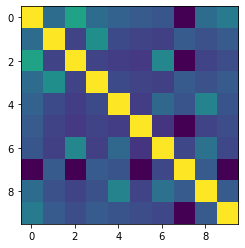

In [21]:
from matplotlib import pyplot as plt
plt.imshow(index)
plt.show()

## 03.06. Recommending FAQs

In [13]:

question = "I have boot problems in my Mac"

#Pre Process the Question 
question_corpus = dictionary.doc2bow(process_document(question))
print("Question translated to :", question_corpus)

#Create an LSI Representation
vec_lsi = lsi[question_corpus]  

#Find similarity of the question with existing documents
sims = index[vec_lsi]  
print("Similarity scores :",list(enumerate(sims)))

Question translated to : [(1, 1), (5, 1)]
Similarity scores : [(0, 0.67856914), (1, 0.47982085), (2, 0.7835442), (3, 0.47982085), (4, -1.4901161e-08), (5, 0.39177215), (6, -5.2154064e-08), (7, -7.450581e-09), (8, 0.47982085), (9, 0.55404943)]


In [23]:
#Find the corresponding FAQ Link

#sort an array in reverse order and get indexes
matches=np.argsort(sims)[::-1] 
print("Sorted Document index :", matches)

print("\n", "-"*60, "\n")
for i in matches:
    print(sims[i], " -> ", helpdesk_data.iloc[i]["Question"])

print("\n", "-"*60, "\n")
print("Recommended FAQ :" , helpdesk_data.iloc[matches[0]]["LinkToAnswer"] )

# Top 3:
print("Recommended FAQ 2:" , helpdesk_data.iloc[matches[1]]["LinkToAnswer"] )
print("Recommended FAQ 3:" , helpdesk_data.iloc[matches[2]]["LinkToAnswer"] )

Sorted Document index : [2 0 9 8 3 1 5 7 4 6]

 ------------------------------------------------------------ 

0.7835442  ->  My Mac is having boot problems, how do I fix it?
0.67856914  ->  My Mac does not boot, what can I do ?
0.55404943  ->  Can I connect two monitors to my Mac?
0.47982085  ->  Can I use a HDMI monitor with my Mac?
0.47982085  ->  Do I need an anti virus on my Mac?
0.47982085  ->  Can Mac Air get infected by a Virus
0.39177215  ->  When my Mac boots, it shows an unsupporterd software error
-7.450581e-09  ->  I see a flicker in my monitor. Is that a virus?
-1.4901161e-08  ->  I have trouble connecting my monitor to my Mac. Can you please help?
-5.2154064e-08  ->  My Monitor does not show in proper resolution when connected to my Mac. How do I fix it?

 ------------------------------------------------------------ 

Recommended FAQ : http://faq/mac-does-not-boot
Recommended FAQ : http://faq/mac-does-not-boot
Recommended FAQ : http://faq/mac-monitorp-setup
